<a href="https://colab.research.google.com/github/rajitakolla/computational_methods/blob/master/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [147]:
# Write your code here
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install spacy
!pip install pyLDAvis

In [150]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [151]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [152]:
import pandas as pd

df = pd.read_csv("/content/q1_data.csv")
#display only 10
df.head(5)

,Title,Author
0,Data science in action,"W Van Der Aalst - Process mining, 2016 - Springer"
1,Data science and its relationship to big data ...,"F Provost, T Fawcett - Big data, 2013 - lieber..."
2,Data Science for Business: What you need to kn...,"F Provost, T Fawcett - 2013 - books.google.com"
3,Data science and prediction,"V Dhar - Communications of the ACM, 2013 - dl...."
4,"Data science, predictive analytics, and big da...","MA Waller, SE Fawcett - Journal of Business Lo..."


In [153]:
df["Title"]=df["Title"].str.lower()
# Convert to list
data = df["Title"].values.tolist()

#remove end spacings
data = [re.sub(" $","",sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:5])

['data science in action', 'data science and its relationship to big data and data-driven decision making', 'data science for business: what you need to know about data mining and data-analytic thinking', 'data science and prediction', 'data science, predictive analytics, and big data: a revolution that will transform supply chain design and management']


In [154]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:5])

[['data', 'science', 'in', 'action'], ['data', 'science', 'and', 'its', 'relationship', 'to', 'big', 'data', 'and', 'data', 'driven', 'decision', 'making'], ['data', 'science', 'for', 'business', 'what', 'you', 'need', 'to', 'know', 'about', 'data', 'mining', 'and', 'data', 'analytic', 'thinking'], ['data', 'science', 'and', 'prediction'], ['data', 'science', 'predictive', 'analytics', 'and', 'big', 'data', 'revolution', 'that', 'will', 'transform', 'supply', 'chain', 'design', 'and', 'management']]


In [155]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['data', 'science', 'in', 'action']


In [156]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [157]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['datum', 'science', 'action']]


In [158]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [159]:
res = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:]]

In [192]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=13,random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [193]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.080*"science" + 0.048*"datum" + 0.033*"information" + 0.033*"model" + '
  '0.017*"teach" + 0.017*"study" + 0.017*"distil" + 0.017*"law" + 0.017*"free" '
  '+ 0.017*"experimental"'),
 (1,
  '0.072*"science" + 0.049*"nuclear" + 0.025*"vii" + 0.025*"evaluate" + '
  '0.025*"technology" + 0.025*"next" + 0.025*"generation" + 0.025*"data" + '
  '0.025*"endf" + 0.025*"unnatural"'),
 (2,
  '0.175*"datum" + 0.038*"mining" + 0.026*"protein" + 0.026*"network" + '
  '0.026*"big" + 0.026*"science" + 0.026*"citation" + 0.013*"ranking" + '
  '0.013*"impact" + 0.013*"web"'),
 (3,
  '0.097*"science" + 0.037*"research" + 0.025*"fair" + 0.025*"global" + '
  '0.025*"change" + 0.025*"big" + 0.025*"datum" + 0.013*"citizen" + '
  '0.013*"cloud" + 0.013*"guide"'),
 (4,
  '0.071*"science" + 0.036*"new" + 0.019*"application" + 0.019*"method" + '
  '0.019*"reference" + 0.019*"industry" + 0.019*"comprehensive" + '
  '0.019*"mining" + 0.019*"statistic" + 0.019*"tool"'),
 (5,
  '0.070*"datum" + 0.056*"data

In [194]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.28346451193514

Coherence Score:  0.3820797820231261


In [ ]:
!pip install --upgrade gensim

In [124]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [195]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=13, id2word=id2word)

In [197]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(3,
  [('mining', 0.2),
   ('cluster', 0.06666666666666667),
   ('comprehensive', 0.03333333333333333),
   ('industry', 0.03333333333333333),
   ('quality', 0.03333333333333333),
   ('administrative', 0.03333333333333333),
   ('genomic', 0.03333333333333333),
   ('machine', 0.03333333333333333),
   ('section', 0.03333333333333333),
   ('reference', 0.03333333333333333)]),
 (1,
  [('scientific', 0.15384615384615385),
   ('workflow', 0.07692307692307693),
   ('political', 0.07692307692307693),
   ('fair', 0.038461538461538464),
   ('evil', 0.038461538461538464),
   ('cluster', 0.038461538461538464),
   ('analyze', 0.038461538461538464),
   ('potential', 0.038461538461538464),
   ('management', 0.038461538461538464),
   ('infrastructure', 0.038461538461538464)]),
 (12,
  [('science', 0.38095238095238093),
   ('introduction', 0.047619047619047616),
   ('fair', 0.047619047619047616),
   ('storage', 0.023809523809523808),
   ('econometric', 0.023809523809523808),
   ('high', 0.0238095238095

In [182]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7786503113064759


In [198]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [199]:
model_list, coherence_values_lda = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [200]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)

In [186]:
for m, cv in zip(x, coherence_values_lda):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6823
Num Topics = 8  has Coherence Value of 0.7721
Num Topics = 14  has Coherence Value of 0.7539
Num Topics = 20  has Coherence Value of 0.7661
Num Topics = 26  has Coherence Value of 0.7542
Num Topics = 32  has Coherence Value of 0.7388
Num Topics = 38  has Coherence Value of 0.7274


**Here the coherence score is increasing for every topic. Hence the model is realtively acceptable**

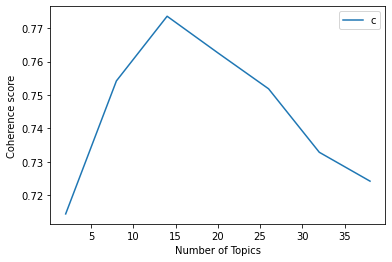

In [187]:
plt.plot(x, coherence_values_lda)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**The coherence value is maximum at the value 13**


In [202]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.214*"mining" + 0.107*"management" + 0.071*"change" + 0.036*"fair" + '
  '0.036*"natural" + 0.036*"link" + 0.036*"plan" + 0.036*"investment" + '
  '0.036*"section" + 0.036*"holographic"'),
 (1,
  '0.056*"generation" + 0.056*"mission" + 0.056*"wise" + 0.056*"key" + '
  '0.056*"resolution" + 0.056*"design" + 0.056*"qualitative" + '
  '0.056*"citation" + 0.056*"increasingly" + 0.056*"infrastructure"'),
 (2,
  '0.364*"datum" + 0.212*"big" + 0.061*"analyze" + 0.030*"master" + '
  '0.030*"gateway" + 0.030*"transform" + 0.030*"decay" + 0.030*"make" + '
  '0.030*"econometric" + 0.030*"mineralogical"'),
 (3,
  '0.190*"model" + 0.095*"fair" + 0.048*"base" + 0.048*"technique" + '
  '0.048*"construct" + 0.048*"citation" + 0.048*"social" + 0.048*"list" + '
  '0.048*"dimensionality" + 0.048*"processing"'),
 (4,
  '0.125*"protein" + 0.125*"science" + 0.062*"network" + 0.062*"comprehensive" '
  '+ 0.062*"management" + 0.031*"message" + 0.031*"solution" + 0.031*"system" '
  '+ 0.031*"customer"

**Graph for topics**

In [201]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.140998  0.032622       1        1  12.220359
7     -0.099521 -0.066055       2        1  11.799447
2      0.077094 -0.167473       3        1  11.469872
10     0.113290  0.058649       4        1  10.520231
5      0.026258 -0.054901       5        1  10.118683
11     0.075052  0.065158       6        1   8.346212
0      0.021762  0.007299       7        1   8.236421
4     -0.091495 -0.013163       8        1   7.135582
8     -0.017659 -0.011010       9        1   6.415533
6      0.024772 -0.024071      10        1   4.583299
1     -0.006479  0.101402      11        1   4.522886
9      0.019002  0.030712      12        1   3.268748
12    -0.001079  0.040830      13        1   1.362728, topic_info=           Term       Freq      Total Category  logprob  loglift
1         datum  30.000000  30.000000  Default  30.0000  30.0000
73         data   7.000000   7.000000  Default  29.0000  29.0000
146   structure   3.000000   3.000000  Default  28.0000  28.0000
122         new   3.000000   3.000000  Default  27.0000  27.0000
2       science  32.000000  32.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
158     quality   0.020339   1.935071  Topic13  -5.8081  -0.2597
161        link   0.020339   1.916045  Topic13  -5.8081  -0.2498
162      stream   0.020339   1.946400  Topic13  -5.8081  -0.2655
163  investment   0.020339   1.312560  Topic13  -5.8081   0.1285
170     cluster   0.020339   2.645693  Topic13  -5.8081  -0.5725

[546 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
77        9  0.827272  acquisition
0         2  0.761869       action
225       4  0.568292          age
90        4  0.376411    algorithm
90        6  0.376411    algorithm
...     ...       ...          ...
114       3  0.763333          web
206       2  0.761868          win
126       5  0.771868         wise
148       2  0.494474     workflow
63        4  0.767153        yield

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 3, 11, 6, 12, 1, 5, 9, 7, 2, 10, 13])

**Summarized topics results**



1.   Investment in change of mining concepts to increase a fair change in revenue
2.   Design of qualitative infrastructure which increases the demands for the generations
3.   Transform Big data to analyze the economic startagies
4.   Construct a fair model for dimensionality reduction technique
5.   Comprehensive network solution for customer management
6.   Analyze large data structures for creating acheiving fair computational predictions
7.   Analyze the global problems and delevelop products for community growth
8.   Hand guide for information and knowledge discovery
9.   Introduction for multivarient data handling. 





## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [205]:
number_of_topics = 7

In [206]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model 
    return dictionary,doc_term_matrix

In [207]:
from gensim.models import LsiModel
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [208]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [216]:
dictionary,doc_term_matrix=prepare_corpus(data_lemmatized)
model_list_lsa, coherence_values_lsa = compute_coherence_values(dictionary, doc_term_matrix,data_lemmatized,40,2,6)

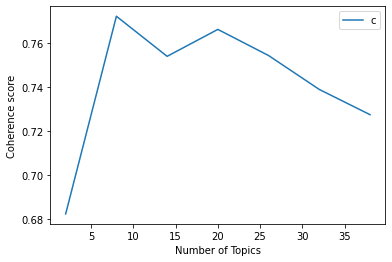

In [217]:
plt.plot(x, coherence_values_lsa)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [218]:
# Write your code here
for m, cv in zip(x, coherence_values_lsa):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4457
Num Topics = 8  has Coherence Value of 0.4457
Num Topics = 14  has Coherence Value of 0.3669
Num Topics = 20  has Coherence Value of 0.4457
Num Topics = 26  has Coherence Value of 0.4457
Num Topics = 32  has Coherence Value of 0.4457
Num Topics = 38  has Coherence Value of 0.4457


In [219]:
# Select the model and print the topics
optimal_model_lsa = model_list_lsa[2]
model_topics_lsa = optimal_model_lsa.show_topics(formatted=False)
pprint(optimal_model_lsa.print_topics(num_words=10))

[(0,
  '0.755*"datum" + 0.562*"science" + 0.106*"mining" + 0.096*"big" + '
  '0.082*"analytic" + 0.063*"knowledge" + 0.055*"relationship" + 0.054*"data" '
  '+ 0.053*"management" + 0.050*"business"'),
 (1,
  '0.744*"science" + -0.538*"datum" + -0.128*"big" + 0.085*"research" + '
  '0.079*"change" + -0.077*"protein" + -0.069*"analytic" + -0.069*"mining" + '
  '0.053*"scientific" + 0.052*"citizen"'),
 (2,
  '0.622*"data" + 0.372*"nuclear" + 0.234*"endf" + 0.234*"technology" + '
  '0.234*"vii" + 0.158*"structure" + 0.144*"product" + 0.139*"next" + '
  '0.138*"evaluate" + 0.138*"generation"'),
 (3,
  '-0.388*"data" + -0.378*"big" + -0.276*"analytic" + -0.245*"new" + '
  '0.232*"nuclear" + 0.178*"technology" + 0.178*"endf" + 0.178*"vii" + '
  '0.174*"protein" + -0.125*"structure"'),
 (4,
  '-0.293*"protein" + -0.292*"data" + 0.274*"big" + -0.263*"network" + '
  '0.245*"analytic" + 0.242*"new" + 0.220*"nuclear" + -0.186*"fair" + '
  '0.161*"technology" + 0.161*"endf"'),
 (5,
  '-0.341*"resea

In [220]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(data_lemmatized,number_of_topics,words)
pprint(model)

[(0, '0.755*"datum" + 0.562*"science" + 0.106*"mining" + 0.096*"big" + 0.082*"analytic" + 0.063*"knowledge" + 0.055*"relationship" + 0.054*"data" + 0.053*"management" + 0.050*"business"'), (1, '0.744*"science" + -0.538*"datum" + -0.128*"big" + 0.085*"research" + 0.079*"change" + -0.077*"protein" + -0.069*"analytic" + -0.069*"mining" + 0.053*"scientific" + 0.052*"citizen"'), (2, '-0.622*"data" + -0.372*"nuclear" + -0.234*"vii" + -0.234*"endf" + -0.234*"technology" + -0.158*"structure" + -0.144*"product" + -0.139*"next" + -0.138*"evaluate" + -0.138*"generation"'), (3, '0.388*"data" + 0.378*"big" + 0.276*"analytic" + 0.245*"new" + -0.232*"nuclear" + -0.178*"technology" + -0.178*"endf" + -0.178*"vii" + -0.174*"protein" + 0.125*"structure"'), (4, '0.293*"protein" + 0.292*"data" + -0.274*"big" + 0.263*"network" + -0.245*"analytic" + -0.242*"new" + -0.220*"nuclear" + 0.186*"fair" + -0.161*"endf" + -0.161*"vii"'), (5, '0.341*"research" + -0.329*"fair" + 0.283*"protein" + 0.261*"global" + 0.254

**Summarized topics**

1.   Data Management for business analytics and Knowledge management
2.   Data mining and analytics for big data research
3.   Data Structures.
4.   Big data analytics for technology and management
5.   Analysis of Protien structure
6.   Research for change in protien structure
7.   Change in biodiversity. Management of networks

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

**LSA**



LSA is used for identifying themes in database of text. The core idea is to convert the data to matrix which contains the terms and the topics. Based on the matric we can effectively perform Topic modelling
by decomposing the terms to a seperate topic-term matrix and document-term matrix. We acheived a choherance score around .45

**LDA**

LDA is used for solving topic modelling problems. The core idea is to process the document term matrix and the topic term matrix and perfom the topic modelling. LDA uses the training data set and learns from the Unstructured groups. So most of the topics are quite similar. We acheived coherence score around .73

We got more number of topics for LDA than LSA with more coherence score. The increase in coherence scores gives the increas ein effeciency. Hence we can say that LDA is better for topic modelling . In real case scenario also LSA mainly focuses on dimentionality reduction